In [1]:
SEED = 42

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.utils import shuffle

In [98]:
df_train = pd.read_csv("dataTrain_13_EXP_av37.csv")
df_test = pd.read_csv("test.csv")
df_train.head()

,Unnamed: 0,id,gender,carType,carCategory,occupation,age,carGroup,bonus,carValue,...,claimValue,catAge,catClaims,catDensity,catClaimNumber,catExposure,catCarValue,ClaimValueExp,ClaimNumberExp,ClaimNumberExpArrondie
0,1,1,Female,A,Small,Unemployed,20,10,-10,24355,...,0.0,u25,u500,u175,zero,91-364,0-32000,0.0,0.0,0
1,2,2,Male,E,Small,Employed,35,12,20,6410,...,0.0,u50,u500,u75,zero,365,0-32000,0.0,0.0,0
2,3,3,Female,D,Medium,Employed,31,8,130,18545,...,0.0,u32,u500,u75,zero,365,0-32000,0.0,0.0,0
3,4,4,Male,D,Large,Employed,29,13,-50,18015,...,0.0,u32,u500,p175,zero,91-364,0-32000,0.0,0.0,0
4,5,5,Male,B,Medium,Self-employed,33,11,150,12325,...,0.0,u50,u500,u75,zero,91-364,0-32000,0.0,0.0,0


(3 - a - b)PP = PP0

In [85]:
mask_un = df_train.catClaimNumber == "un"
mask_p2 = df_train.catClaimNumber == "p2"

pp1 = df_train[mask_un].claimValue.mean()
pp2 = df_train[mask_p2].claimValue.mean()

In [94]:
pp1 = df_train[mask_un].claimValue.mean()

In [95]:
pp1

1747.1658587632858

In [96]:
pp2 = df_train[mask_p2].claimValue.mean()
pp2

3496.7989595975987

In [97]:
pp = df_train.claimValue.mean()
pp

315.3684011625338

## Feature engineering

Nous allons réduire le nombre de variables, notamment subregions en utilisant les test de contingence du $\chi^2$ réalisés sour R afin d'isoler les modalités significatives

In [24]:
significative_subRegions_claimNumber = {"N8", "M4", "Q13", "Q24", "Q26", "R1", "R11", "R12", "R15", "R16", "R5", "R8", "L72"}
significative_carType_claimNumber = {"D", "E"}

significative_subRegion_claimValue = {"L68", "L79", "L81", "L86", "O28", "P26", "P7", "S19", "S9"}
significative_carType_claimValue = {"E"}
significative_occupation_claimValue = {"HouseWife", "Unemployed"}

In [25]:
def getSignificativeFeatures(row, significative_features, default_other="other"):
    """
    check if row is in significative_features (significative subRegion) and assigns default_other if not
    the goal here is to reduce the number of features
    """
    if row in significative_features:
        return row
    else: return default_other

getSignificativeFeatures("N8", significative_features=significative_subRegions_claimNumber), getSignificativeFeatures("A", significative_features=significative_carType_claimNumber)

('N8', 'other')

In [99]:
df_train["significativeCarType_claimNumber"] = df_train.carType.apply(
    lambda row: getSignificativeFeatures(
        row, 
        significative_features=significative_carType_claimNumber
    )
)
df_train["significativeSubRegion_claimNumber"] = df_train.subRegion.apply(
    lambda row: getSignificativeFeatures(
        row,
        significative_features=significative_subRegions_claimNumber
    )
)
df_train["significativeSubRegion_claimValue"] = df_train.subRegion.apply(
    lambda row: getSignificativeFeatures(
        row,
        significative_features=significative_subRegion_claimValue
    )
)
df_train["significativeCarType_claimValue"] = df_train.carType.apply(
    lambda row: getSignificativeFeatures(
        row,
        significative_features=significative_carType_claimValue
    )
)
df_train["significativeOccupation_claimValue"] = df_train.occupation.apply(
    lambda row: getSignificativeFeatures(
        row,
        significative_features=significative_occupation_claimValue
    )
)

In [28]:
df_train.columns

Index(['Unnamed: 0', 'id', 'gender', 'carType', 'carCategory', 'occupation',
       'age', 'carGroup', 'bonus', 'carValue', 'material', 'subRegion',
       'region', 'cityDensity', 'exposure', 'claimNumber', 'claimValue',
       'catAge', 'catClaims', 'catDensity', 'catClaimNumber', 'catExposure',
       'catCarValue', 'ClaimValueExp', 'ClaimNumberExp',
       'ClaimNumberExpArrondie', 'significativeCarType_claimNumber',
       'significativeSubRegion_claimNumber',
       'significativeSubRegion_claimValue', 'significativeCarType_claimValue',
       'significativeOccupation_claimValue'],
      dtype='object')

Une dernière rapide étude de correlation

In [18]:
cor = df_train.corr(method="pearson")
print(cor)

                   id       age  carGroup     bonus  material  cityDensity  \
id           1.000000  0.000697 -0.002313  0.004905 -0.001165     0.001113   
age          0.000697  1.000000  0.067530 -0.162014  0.157458    -0.002800   
carGroup    -0.002313  0.067530  1.000000 -0.022583  0.021568     0.003851   
bonus        0.004905 -0.162014 -0.022583  1.000000 -0.040544    -0.001577   
material    -0.001165  0.157458  0.021568 -0.040544  1.000000    -0.000479   
cityDensity  0.001113 -0.002800  0.003851 -0.001577 -0.000479     1.000000   
claimValue   0.001563 -0.068588  0.013673  0.063285 -0.038726     0.048194   

             claimValue  
id             0.001563  
age           -0.068588  
carGroup       0.013673  
bonus          0.063285  
material      -0.038726  
cityDensity    0.048194  
claimValue     1.000000  


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_19192/3785685368.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


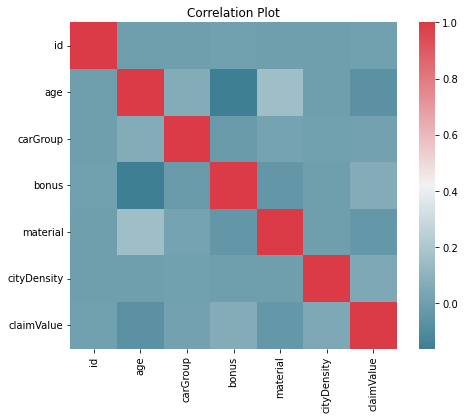

In [19]:
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

Now we can focus narrow down on specific columns to reduce dimensonnality

In [29]:
cols_claimNumber = ["id", "gender", "carCategory", "occupation", "age", "carGroup", "bonus", "material", "cityDensity", "significativeCarType_claimNumber", "significativeSubRegion_claimNumber", "catClaimNumber"]
cols_claimValue = ["id", "gender", "carCategory", "significativeOccupation_claimValue", "age", "carGroup", "bonus", "material", "cityDensity", "significativeCarType_claimValue", "significativeSubRegion_claimValue", "claimValue"]

In [100]:
df_train = shuffle(df_train, random_state=SEED)
df_train_claimNumber = df_train[cols_claimNumber]
df_train_claimValue = df_train[cols_claimValue]
# variables explicatives pour prédire claimValue (régression) et catClaimNumber (classification)
X_train_claimValue = df_train_claimValue[:50000].drop(columns=['id', 'claimValue'])
X_train_claimNumber = df_train_claimNumber[:50000].drop(columns=['id', 'catClaimNumber'])
X_train_ids = df_train[:50000]['id']
# Ground truth
y_train_claimNumber = df_train_claimNumber[:50000]['catClaimNumber']
y_train_claimValue = df_train_claimValue[:50000]['claimValue']

# Validation set 
X_val_claimValue = df_train_claimValue[50000:].drop(columns=['id', 'claimValue'])
X_val_claimNumber = df_train_claimNumber[50000:].drop(columns=['id', 'catClaimNumber'])
X_val_ids = df_train[50000:]['id']

y_val_claimNumber = df_train_claimNumber[50000:]['catClaimNumber']
y_val_claimValue = df_train_claimValue[50000:]['claimValue']

In [40]:
X_train_claimNumber.head()

,gender,carCategory,occupation,age,carGroup,bonus,material,cityDensity,significativeCarType_claimNumber,significativeSubRegion_claimNumber
12628,Female,Medium,Self-employed,22,3,-20,1,190.05160,other,M4
37730,Male,Large,Unemployed,63,5,-30,1,98.10373,other,other
39991,Male,Medium,Unemployed,37,13,60,0,24.11879,other,other
8525,Male,Medium,Unemployed,41,13,-40,1,125.13200,other,other
8279,Female,Large,Unemployed,22,9,60,1,58.59040,E,other


One hot encoding

In [101]:
X_train_claimNumber, X_val_claimNumber = pd.get_dummies(X_train_claimNumber), pd.get_dummies(X_val_claimNumber)
X_train_claimValue, X_val_claimValue = pd.get_dummies(X_train_claimValue), pd.get_dummies(X_val_claimValue)

# y_train_claimNumber, y_val_claimNumber = pd.get_dummies(y_train_claimNumber), pd.get_dummies(y_val_claimNumber)

In [42]:
X_train_claimNumber.shape, X_val_claimNumber.shape

((50000, 32), (10000, 32))

On a largement réduit la dimensionalité en passant de plus de 500 features à seulement 32 !  

## Models

### Random Forest Classifier

In [46]:
rfc = RandomForestClassifier(random_state=SEED)

param_grid = {
    "n_estimators": [250, 500, 750, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [3, 4, 5, 6, 7],
    'criterion': ['gini', 'entropy']
}

In [47]:
rfc_claimNumber = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3, verbose=2, scoring='roc_auc', refit='AUC', return_train_score=True)
rfc_claimNumber.fit(X_train_claimNumber, y_train_claimNumber)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[CV] END criterion=gini, max_depth=3, max_features=auto, n_estimators=250; total time=   6.5s
[CV] END criterion=gini, max_depth=3, max_features=auto, n_estimators=250; total time=   5.4s
[CV] END criterion=gini, max_depth=3, max_features=auto, n_estimators=250; total time=   5.4s
[CV] END criterion=gini, max_depth=3, max_features=auto, n_estimators=500; total time=  13.3s
[CV] END criterion=gini, max_depth=3, max_features=auto, n_estimators=500; total time=  12.5s
[CV] END criterion=gini, max_depth=3, max_features=auto, n_estimators=500; total time=  10.6s
[CV] END criterion=gini, max_depth=3, max_features=auto, n_estimators=750; total time=  16.0s
[CV] END criterion=gini, max_depth=3, max_features=auto, n_estimators=750; total time=  16.0s
[CV] END criterion=gini, max_depth=3, max_features=auto, n_estimators=750; total time=  16.9s
[CV] END criterion=gini, max_depth=3, max_features=auto, n_estimators=1000; total time=  21

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [250, 500, 750, 1000]},
             refit='AUC', return_train_score=True, scoring='roc_auc',
             verbose=2)

In [48]:
rfc_claimNumber.best_estimator_

RandomForestClassifier(max_depth=7, n_estimators=1000, random_state=42)

In [49]:
rfc_claimNumber.best_score_

0.766021605160498

In [50]:
rfc_claimNumber.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 1000}

In [102]:
rfc_best_claimNumber = RandomForestClassifier(random_state=SEED, **rfc_claimNumber.best_params_)

In [103]:
rfc_best_claimNumber.fit(X_train_claimNumber, y_train_claimNumber)

y_pred_prob_claimNumber = rfc_best_claimNumber.predict_proba(X_val_claimNumber)
y_pred_claimNumber = rfc_best_claimNumber.predict(X_val_claimNumber)

In [61]:
y_train_claimNumber

,p2,un,zero
12628,0,0,1
37730,0,0,1
39991,1,0,0
8525,0,0,1
8279,0,0,1
...,...,...,...
31663,0,0,1
52944,1,0,0
11560,0,0,1
38411,0,0,1


In [105]:
y_pred_prob_claimNumber[:5]

array([[0.048559, 0.204175, 0.747266],
       [0.005741, 0.078275, 0.915984],
       [0.014867, 0.110336, 0.874797],
       [0.048646, 0.190281, 0.761073],
       [0.028325, 0.156533, 0.815142]])

In [122]:
# saving this prediction for later
np.save("models/rfc_gini_7_auto_1000_claimNumber_proba_val.npy", y_pred_prob_claimNumber)

### XGBoost

In [76]:
# changing how numpy sisplays numbers
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In [70]:
from xgboost import XGBClassifier

naive_xgboost_claimNumber = XGBClassifier(max_depth=7, n_estimators=750)

We need to encode categorical output values 

In [107]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_claimNumber = le.fit_transform(y_train_claimNumber)

In [108]:
naive_xgboost_claimNumber.fit(X_train_claimNumber, y_train_claimNumber)
y_pred_proba_train_claimNumber = naive_xgboost_claimNumber.predict_proba(X_train_claimNumber)
y_pred_proba_val_claimNumber = naive_xgboost_claimNumber.predict_proba(X_val_claimNumber)

[23:35:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



In [109]:
y_pred_proba_train_claimNumber[:5]

array([[0.000095, 0.004335, 0.995570],
       [0.000001, 0.000994, 0.999005],
       [0.929569, 0.019917, 0.050513],
       [0.000077, 0.166485, 0.833438],
       [0.000103, 0.012203, 0.987695]], dtype=float32)

In [75]:
y_val_claimNumber[:5]

,p2,un,zero
3675,0,0,1
15450,0,0,1
20608,0,0,1
46531,0,1,0
6749,0,0,1


In [110]:
y_train_pred_claimNumber = naive_xgboost_claimNumber.predict(X_train_claimNumber)
y_val_pred_claimNumber = naive_xgboost_claimNumber.predict(X_val_claimNumber)

In [115]:
le.inverse_transform(y_val_pred_claimNumber)[:5]

array(['zero', 'zero', 'zero', 'zero', 'zero'], dtype=object)

In [112]:
y_pred_proba_val_claimNumber[:5]

array([[0.000595, 0.269743, 0.729662],
       [0.000038, 0.016308, 0.983654],
       [0.000192, 0.001092, 0.998716],
       [0.003797, 0.073458, 0.922745],
       [0.000398, 0.133179, 0.866423]], dtype=float32)

In [114]:
print(classification_report(le.inverse_transform(y_val_pred_claimNumber), y_val_claimNumber))

              precision    recall  f1-score   support

          p2       0.09      0.27      0.14        85
          un       0.11      0.30      0.16       464
        zero       0.96      0.86      0.91      9451

    accuracy                           0.83     10000
   macro avg       0.39      0.48      0.40     10000
weighted avg       0.92      0.83      0.87     10000



In [128]:
np.array(pd.get_dummies(y_val_claimNumber))

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]], dtype=uint8)

In [125]:
np.save("models/xgboost_7_750_proba_val.npy", y_pred_proba_val_claimNumber)

In [129]:
np.save("models/GroundTruth_claimNumber.npy", np.array(pd.get_dummies(y_val_claimNumber)))

In [116]:
from sklearn.metrics import roc_auc_score

prob_xgb_p2 = [p[0] for p in y_pred_proba_val_claimNumber]
prob_xgb_one = [p[1] for p in y_pred_proba_val_claimNumber]
prob_xgb_zero = [p[2] for p in y_pred_proba_val_claimNumber]
# Ground Truth in a dataframe
y_GT_p2 = np.array(y_val_claimNumber.p2)
y_GT_one = np.array(y_val_claimNumber.un)
y_GT_zero = np.array(y_val_claimNumber.zero)

print(f"ROC score on validation set for claimNumber = p2: {roc_auc_score(y_GT_p2, prob_xgb_p2)}")
print(f"ROC score on validation set for claimNumber = one: {roc_auc_score(y_GT_one, prob_xgb_one)}")
print(f"ROC score on validation set for claimNumber = zero: {roc_auc_score(y_GT_zero, prob_xgb_zero)}")

AttributeError: 'Series' object has no attribute 'p2'